# Predictions 
## Niccolò Simonato 
## Data & Web Mining, Academic Year 2021-2022

## Importing the dependencies and the cleaned dataset

The cleaned dataset is now imported.

The first snipped is intended to be used in the Google Drive environment, just set the path variable as needed.

The second one is intended to be used in the Jupyter Notebook environment.

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import floor, log10
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# path = '/gdrive/MyDrive/Progetto DWM/Data/*.csv'
# %cd /gdrive

In [3]:
path = 'Data/'

# cleaned_df = pd.read_csv(path, low_memory = False)
train_datasets = []
test_datasets = []

for i in range(4):
    train_datasets.append(pd.read_csv(f"{path}train_dataset_2016_{i + 1}.csv", low_memory = True))
    test_datasets.append(pd.read_csv(f"{path}test_dataset_2016_{i + 1}.csv", low_memory = True))

## Data Validation
In order to prevent any exception to be raised, we will check the state of each dataset and will ensure that the data can be used.

In [4]:
train_datasets[1].describe(include='all')

,Unnamed: 0,parcelid,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,structuretaxvaluedollarcnt,assessmentyear,logerror,N-LivingAreaError
count,63945.000000,6.394500e+04,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000,63945.000000,63945.0,63945.000000,63945.0
mean,48882.100227,1.300342e+07,1744.500774,0.451234,0.661069,0.003954,16.667683,0.018100,2015.0,0.012324,1.0
std,28905.336939,2.423721e+06,904.481611,0.181467,0.192405,0.016580,18.109890,0.020831,0.0,0.155913,0.0
min,0.000000,1.071174e+07,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.0,-3.194000,1.0
25%,16874.000000,1.154290e+07,1172.000000,0.317044,0.544646,0.000765,1.000000,0.008191,2015.0,-0.024300,1.0
50%,56386.000000,1.258800e+07,1516.000000,0.462381,0.678780,0.000992,8.000000,0.013270,2015.0,0.006000,1.0
75%,73348.000000,1.425320e+07,2059.000000,0.566001,0.809982,0.001610,38.000000,0.021189,2015.0,0.038300,1.0
max,90272.000000,1.629608e+08,20013.000000,1.000000,1.000000,1.000000,51.000000,1.000000,2015.0,4.737000,1.0


Since we don't have any real use for it, we can drop the `parcelid` feature. We will also drop , `Unnamed: 0` because it's a duplicate of `parcelid`.

`assessmentyear` and `N-LivingAreaError` can be also dropped since the remaining values are for the most part the same.

In [5]:
for i in train_datasets:
    i.drop(['parcelid','Unnamed: 0','assessmentyear', 'N-LivingAreaError'], axis=1, inplace=True)

for i in test_datasets:
    i.drop(['parcelid','Unnamed: 0','assessmentyear', 'N-LivingAreaError'], axis=1, inplace=True)

Let's analyze the scales of the values we have left. It looks like some features such as `calculatedfinishedsquarefeet` and `propertycountylandusecode` have much larger scales than the others. We will rescale all the features to the interval $[0,1]$, in order to have standardized values. We will use the same function that we used in the EDA notebook.

In [6]:
def MinMaxRescaling(features, min_v=0, max_v=1):
    scaler = MinMaxScaler(feature_range=(min_v, max_v), copy=False) #in place
    scaler.fit(features)
    return scaler.transform(features)

In [7]:
for i in train_datasets:
    i[['calculatedfinishedsquarefeet','propertycountylandusecode']] = MinMaxRescaling(i[['calculatedfinishedsquarefeet','propertycountylandusecode']])

for i in test_datasets:
    i[['calculatedfinishedsquarefeet','propertycountylandusecode']] = MinMaxRescaling(i[['calculatedfinishedsquarefeet','propertycountylandusecode']])

## Predictions - Attempt 1 - k-NN algorithm

### Why k-NN? - Introduction 
I chose the k-NN algorithm because, usually, the house construction doesn't happen randomly. It's really unusual that a private party builds his own house, with his own money, and wherever he likes: it's more likely that the municipality's dedicated office decides where and how the houses of a given zone are going to be buildt. 

Therefore, i think is safe to assume that houses of a given zone will have similar prices. The k-NN hopefully will help achiving this target. 

This attempt will use the [ScikitLearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) of the k-NN algorithm for prediction.

The first attempt will be conducted with the parameter `weights` set as "uniform", the second one will use the value "distance".

The model will be tested with a number of neighbors beetween 2 and 20, because usually these are the value that yield the best results.

The following snippet contains the functions that wrap the described procedures.

In [8]:
train, test = None, None
n_neighbors = list(range(2,21))
results = []
types = ['distance', 'uniform']
to_Y = ['logerror']
to_X = list(set(train_datasets[1].columns) - set('logerror'))
def train_test_kNN(x_train, y_train, x_test, y_test, n_neighbors, w='distance'):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=w)
    model = knn.fit(x_train, y_train)
    prediction = model.predict(x_test)
    scores = model.score(x_test, y_test)
    diff = x_test.copy()
    diff['diff'] = y_test - prediction
    diff['diff'] = diff['diff'].abs()
    data = {'n_neighbors': n_neighbors, 
            'weights': w,
            'prediction': prediction,
            'score' : scores,
            'MSE': mean_squared_error(y_test,prediction),
            'diff': diff
           }
    return data

In [9]:
%%time
for i in range(len(train_datasets)):
    train = train_datasets[i]
    test  = test_datasets[i]
    for n in n_neighbors:
        for w in types:
            timestamp1 = datetime.now()
            print(f"[START - Dataset {i + 1}] at {timestamp1}: n_neighbor = {n}, weight = {w}")
            results.append(train_test_kNN(train[to_X], train[to_Y], test[to_X], test[to_Y], n, w))
            timestamp2 = datetime.now()
            difference = timestamp2 - timestamp1
            print(f"[END   - Dataset {i + 1}] at {timestamp2} after {difference.total_seconds()} seconds. ")

[START - Dataset 1] at 2022-06-21 12:59:59.259655: n_neighbor = 2, weight = distance
[END   - Dataset 1] at 2022-06-21 13:00:00.395432 after 1.135777 seconds. 
[START - Dataset 1] at 2022-06-21 13:00:00.395432: n_neighbor = 2, weight = uniform
[END   - Dataset 1] at 2022-06-21 13:00:01.525166 after 1.129734 seconds. 
[START - Dataset 1] at 2022-06-21 13:00:01.525166: n_neighbor = 3, weight = distance
[END   - Dataset 1] at 2022-06-21 13:00:02.749786 after 1.22462 seconds. 
[START - Dataset 1] at 2022-06-21 13:00:02.749786: n_neighbor = 3, weight = uniform
[END   - Dataset 1] at 2022-06-21 13:00:03.976027 after 1.226241 seconds. 
[START - Dataset 1] at 2022-06-21 13:00:03.976027: n_neighbor = 4, weight = distance
[END   - Dataset 1] at 2022-06-21 13:00:05.369769 after 1.393742 seconds. 
[START - Dataset 1] at 2022-06-21 13:00:05.369769: n_neighbor = 4, weight = uniform
[END   - Dataset 1] at 2022-06-21 13:00:06.786952 after 1.417183 seconds. 
[START - Dataset 1] at 2022-06-21 13:00:06.7

[END   - Dataset 2] at 2022-06-21 13:01:18.180905 after 1.237255 seconds. 
[START - Dataset 2] at 2022-06-21 13:01:18.181672: n_neighbor = 9, weight = distance
[END   - Dataset 2] at 2022-06-21 13:01:19.444155 after 1.262483 seconds. 
[START - Dataset 2] at 2022-06-21 13:01:19.444155: n_neighbor = 9, weight = uniform
[END   - Dataset 2] at 2022-06-21 13:01:20.697712 after 1.253557 seconds. 
[START - Dataset 2] at 2022-06-21 13:01:20.697712: n_neighbor = 10, weight = distance
[END   - Dataset 2] at 2022-06-21 13:01:22.004581 after 1.306869 seconds. 
[START - Dataset 2] at 2022-06-21 13:01:22.004581: n_neighbor = 10, weight = uniform
[END   - Dataset 2] at 2022-06-21 13:01:23.280091 after 1.27551 seconds. 
[START - Dataset 2] at 2022-06-21 13:01:23.281697: n_neighbor = 11, weight = distance
[END   - Dataset 2] at 2022-06-21 13:01:24.631199 after 1.349502 seconds. 
[START - Dataset 2] at 2022-06-21 13:01:24.631199: n_neighbor = 11, weight = uniform
[END   - Dataset 2] at 2022-06-21 13:01:

[END   - Dataset 3] at 2022-06-21 13:02:28.227982 after 1.507972 seconds. 
[START - Dataset 3] at 2022-06-21 13:02:28.227982: n_neighbor = 16, weight = distance
[END   - Dataset 3] at 2022-06-21 13:02:29.901671 after 1.673689 seconds. 
[START - Dataset 3] at 2022-06-21 13:02:29.902190: n_neighbor = 16, weight = uniform
[END   - Dataset 3] at 2022-06-21 13:02:31.417421 after 1.515231 seconds. 
[START - Dataset 3] at 2022-06-21 13:02:31.417421: n_neighbor = 17, weight = distance
[END   - Dataset 3] at 2022-06-21 13:02:32.897783 after 1.480362 seconds. 
[START - Dataset 3] at 2022-06-21 13:02:32.897783: n_neighbor = 17, weight = uniform
[END   - Dataset 3] at 2022-06-21 13:02:34.351712 after 1.453929 seconds. 
[START - Dataset 3] at 2022-06-21 13:02:34.351712: n_neighbor = 18, weight = distance
[END   - Dataset 3] at 2022-06-21 13:02:35.830648 after 1.478936 seconds. 
[START - Dataset 3] at 2022-06-21 13:02:35.830648: n_neighbor = 18, weight = uniform
[END   - Dataset 3] at 2022-06-21 13:

### How did it go? - Evaluation
After obtaining the results, we can proceed with the evaluation of the results.

In order to keep this notebook as clean as possible, the evaluation will be done with the built-in evaluator of the KNeighborsRegressor object. The evaluation uses the $R^2$ index, the coefficient of determination that is $1 - \frac{u}{v}$, where $u$ is the residual sum of squares and $v$ is the total sum of squares.

We will also use the function "mean_squared_error" from Sklearn's module "metrics", to calculate the $MSE$.

In [25]:
def set_subplot(ax, title, x_label, y_label, color, par, score='score'):
    if score == 'score':
        ax.scatter(par['n_neighbors'], par['score'], color=color, label='data')
    else:
        ax.scatter(par['n_neighbors'], par['MSE'], color=color, label='data')
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

def show_results_kNN(data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    for parameters in data:
        if parameters['weights'] == "uniform":
            set_subplot(ax1, 'Uniform', 'Number of neighbors', 'R^2 index', 'darkorange', parameters)
            set_subplot(ax3, '', 'Number of neighbors', 'Mean Squared Error', 'darkorange', parameters)
        else:
            set_subplot(ax2, 'Distance', 'Number of neighbors', '', 'blue', parameters, score='MSE')
            set_subplot(ax4, '', 'Number of neighbors', '', 'blue', parameters, score='MSE')  
    plt.show()

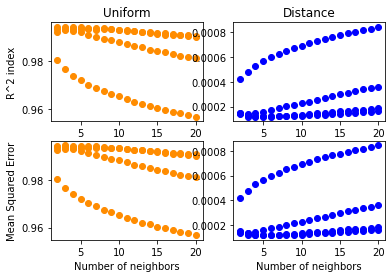

In [26]:
show_results_kNN(results)

It is necessary to remind that by default the "distance" used in those cases is the Minkowski distance. With other parameters, it may have yielded other results, but for the purpose of this project it is a reasonable choice.

These results show that the parameter "weights" yields comparable scores for the two tested values. It looks like the $R^2 index$ gets better as the number of neighbors approaches 5, then it slowly decreases. It happens more or less the same for the $MSE$, but this metric decreases after the aforementioned value.

The results are acceptable for the means of this project, and show that the algorithm probably did not overfit. It is advisable though that more tests are conducted with the 2017 dataset. The value of the $MSE$ metric suggests that the model's precision is acceptable. It looks like increasing the value of $k$ also increases the value of the $MSE$.

We will now try to find some pattern from the instances that yielded the best results and the ones that yielded the worst ones. This comparison will be repeated for the two models with the best and the worst scores.

In order to obtain the best and the worst models, they will be sorted in descending order by the $R^2$ index value and then in ascending order by the $MSE$ value.

In [27]:
best = results
best.sort(key=lambda p: p['score'], reverse=True)
best.sort(key=lambda p: p['MSE'])
worst = best[len(best) - 1]
best = best[0]

In [28]:
best['diff'].iloc[best['diff'].idxmin(), :].describe()

,logerror,calculatedfinishedsquarefeet,latitude,structuretaxvaluedollarcnt,longitude,lotsizesquarefeet,propertycountylandusecode,diff
count,8.000000,8.000000,8.000000,8.000000e+00,8.000000,8.000000,8.000000,8.000000
mean,-0.108762,0.051209,0.431272,1.541482e-02,0.456992,0.001445,0.272959,0.102431
std,1.540822,0.033674,0.217093,1.207413e-02,0.261802,0.001616,0.290656,0.218259
min,-3.194000,0.000000,0.000508,4.020909e-07,0.000270,0.000038,0.000000,0.000000
25%,-0.108950,0.032819,0.340154,6.989445e-03,0.424665,0.000392,0.091837,0.000525
50%,-0.016900,0.065164,0.449701,1.556770e-02,0.566136,0.001072,0.142857,0.008030
75%,0.030275,0.070686,0.569596,2.229144e-02,0.600736,0.001745,0.438776,0.055793
max,2.544000,0.090000,0.695250,3.230448e-02,0.685765,0.005007,0.755102,0.627611


In [29]:
best['diff'].iloc[best['diff'].idxmin(), :].describe()

,logerror,calculatedfinishedsquarefeet,latitude,structuretaxvaluedollarcnt,longitude,lotsizesquarefeet,propertycountylandusecode,diff
count,8.000000,8.000000,8.000000,8.000000e+00,8.000000,8.000000,8.000000,8.000000
mean,-0.108762,0.051209,0.431272,1.541482e-02,0.456992,0.001445,0.272959,0.102431
std,1.540822,0.033674,0.217093,1.207413e-02,0.261802,0.001616,0.290656,0.218259
min,-3.194000,0.000000,0.000508,4.020909e-07,0.000270,0.000038,0.000000,0.000000
25%,-0.108950,0.032819,0.340154,6.989445e-03,0.424665,0.000392,0.091837,0.000525
50%,-0.016900,0.065164,0.449701,1.556770e-02,0.566136,0.001072,0.142857,0.008030
75%,0.030275,0.070686,0.569596,2.229144e-02,0.600736,0.001745,0.438776,0.055793
max,2.544000,0.090000,0.695250,3.230448e-02,0.685765,0.005007,0.755102,0.627611


In [15]:
worst['diff'].iloc[best['diff'].idxmin(), :].describe()

,logerror,calculatedfinishedsquarefeet,latitude,structuretaxvaluedollarcnt,longitude,lotsizesquarefeet,propertycountylandusecode,diff
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.006362,0.085137,0.549478,0.012546,0.555761,0.002219,0.303571,0.006724
std,0.041242,0.049930,0.127969,0.007145,0.223396,0.001830,0.378741,0.009439
min,-0.086600,0.023406,0.370947,0.003308,0.086196,0.000691,0.000000,0.001300
25%,-0.016000,0.061210,0.462667,0.008570,0.514919,0.001186,0.000000,0.001916
50%,0.005000,0.075310,0.589575,0.012126,0.564919,0.001498,0.081633,0.003122
75%,0.014150,0.115105,0.622434,0.016457,0.656849,0.002585,0.704082,0.005289
max,0.041100,0.173376,0.733355,0.025027,0.812639,0.006303,0.795918,0.029010


In [16]:
worst['diff'].iloc[best['diff'].idxmin(), :].describe()

,logerror,calculatedfinishedsquarefeet,latitude,structuretaxvaluedollarcnt,longitude,lotsizesquarefeet,propertycountylandusecode,diff
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.006362,0.085137,0.549478,0.012546,0.555761,0.002219,0.303571,0.006724
std,0.041242,0.049930,0.127969,0.007145,0.223396,0.001830,0.378741,0.009439
min,-0.086600,0.023406,0.370947,0.003308,0.086196,0.000691,0.000000,0.001300
25%,-0.016000,0.061210,0.462667,0.008570,0.514919,0.001186,0.000000,0.001916
50%,0.005000,0.075310,0.589575,0.012126,0.564919,0.001498,0.081633,0.003122
75%,0.014150,0.115105,0.622434,0.016457,0.656849,0.002585,0.704082,0.005289
max,0.041100,0.173376,0.733355,0.025027,0.812639,0.006303,0.795918,0.029010


The major differences that emerges are the following:

* The best predicted and the worst predicted instances for both the best model are very similar.
* The same thing happens with the worst model.
* The best predicted instances are located in different places than the worst ones.
* The scale for the logerror is wider in the best predicted instances.
* The `structuretaxvaluedollarcnt` feature has a much lower scale in the best prediction instances.
* The best predicted instances have a larger scale even for the `diff` values.
* The worst predicted instances have a larger scale for the `calculatedfinishedsquarefeet` feature values.

The other differences that may emerge do not seem to be relevant.

## Predictions - Attempt 2 - Linear Regression

### Why Linear Regression? - Introduction
The idea behind the adoption of the LinReg model is correlated to the low integrity of the inititial dataset. 

In contrast with the previously analyzed model, this is an attempt to see what would happen with an "assumption-free" model. It is expected that this type of analysis will underline some unseen correlations, and also will produce some interesting predictions.

This test will be conducted with the [ScikitLearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) of the LinearRegression.

In [17]:
def train_test_LinReg(x_train, y_train, x_test, y_test):
    model = LinearRegression().fit(x_train, y_train)
    predictions = model.predict(x_test)
    diff = x_test.copy()
    diff['diff'] = y_test - predictions
    diff['diff'] = diff['diff'].abs()
    data = {
        'predictions': predictions,
        'R_sq': model.score(x_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'Adj_R_sq': 1 - (1-model.score(x_test, predictions))*(len(predictions)-1)/(len(predictions)-x_test.shape[1]-1),
        'diff': diff
    }
    return data

In [18]:
%%time
res = []
to_Y = ['logerror']
to_X = list(set(train.columns) - set('logerror'))
for i in range(len(train_datasets)):
    train = train_datasets[i]
    test = test_datasets[i]
    res.append(train_test_LinReg(train[to_X], train[to_Y], test[to_X], test[to_Y]))

CPU times: total: 375 ms
Wall time: 145 ms


### How did it go? - Evaluation
We can now proceed with the evaluation of the results.

The following tests will be used:

*  Mean Squared Error
*  R-squared index
*  Adjusted R-squared index

The evaluations will be done by using the [ScikitLearn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module.

In [19]:
def show_results_LinReg(results):
    for i in range(len(results)):
        parameters = results[i]
        print(f"[Experiment number {i  + 1}]\n[Scores] R_sq index = {parameters['R_sq']}, " + 
              f"MSE = {parameters['MSE']}, Adj_R_sq index = {parameters['Adj_R_sq']}\n\n")

In [20]:
show_results_LinReg(res)

[Experiment number 1]
[Scores] R_sq index = 1.0, MSE = 5.180732657079307e-32, Adj_R_sq index = 1.0


[Experiment number 2]
[Scores] R_sq index = 1.0, MSE = 1.5997705511909795e-31, Adj_R_sq index = 1.0


[Experiment number 3]
[Scores] R_sq index = 1.0, MSE = 4.220604731225047e-32, Adj_R_sq index = 1.0


[Experiment number 4]
[Scores] R_sq index = 1.0, MSE = 4.419750797908636e-32, Adj_R_sq index = 1.0




By looking at the results it is clear that the results are too good to be true. It is clear that this is a case of overfitting. [This article](https://statisticsbyjim.com/regression/r-squared-too-high/) explains the other possible reasons of these results. The final section of the document investigates the causes of this failure.

It may have been interesting analysing the best and the worst prediction instances for the test conducted in this section, but it's clear that that would be pointless, due to the overall failure of the models. 

## Predictions - Attempt 3 - Support Vector Regression

### Why Support Vector Regression? - Introduction

After the failure of the Linear Regression Model, this one should yield better results.

This test will be conducted with the [ScikitLearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) of the Support Vector Regression.

In [21]:
def train_test_SVR(x_train, y_train, x_test, y_test, C_val, Ep_val):
    model = SVR(C=C_val, epsilon=Ep_val).fit(x_train, y_train)
    predictions = model.predict(x_test)
    data = {
        'C': C_val,
        'epsilon': Ep_val,
        'predictions': predictions,
        'R_sq': model.score(x_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'Adj_R_sq': 1 - (1-model.score(x_test, predictions))*(len(predictions)-1)/(len(predictions)-x_test.shape[1]-1),
    }
    return data

The model will be tested with the `C` parameter values ranging in $[0.8,1.2]$, and the values of the `epsilon` parameter ranging in $[0.1,0.3]$.

In [22]:
%%time
res_svr = []
to_Y = ['logerror']
to_X = list(set(train.columns) - set('logerror'))
C_values = [0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]
Ep_values = [0.1,0.2,0.3]
for i in range(len(train_datasets)):
    train = train_datasets[i]
    test = test_datasets[i]
    for c in C_values:
        for ep in Ep_values:
            res_svr.append(train_test_SVR(train[to_X], train[to_Y], test[to_X], test[to_Y], c, ep))

C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nsimo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: total: 55.7 s
Wall time: 57.9 s


### How did it go? - Evaluation
We can now proceed with the evaluation of the results.

The following tests will be used:

*  Mean Squared Error
*  R-squared index
*  Adjusted R-squared index

The evaluations will be done by using the [ScikitLearn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module.

In [23]:
def show_results_SVR(results):
    for i in range(len(results)):
        parameters = results[i]
        print(f"[Experiment number {i  + 1}] \n" +
              f"[Parameters] C: {parameters['C']}, epsilon: {parameters['epsilon']}"
              f"\n[Scores] R_sq index = {parameters['R_sq']}, " + 
              f"MSE = {parameters['MSE']}, Adj_R_sq index = {parameters['Adj_R_sq']}\n\n")

In [24]:
show_results_SVR(res_svr)

[Experiment number 1] 
[Parameters] C: 0.6, epsilon: 0.1
[Scores] R_sq index = 1.0, MSE = 0.00242448755474935, Adj_R_sq index = 1.0


[Experiment number 2] 
[Parameters] C: 0.6, epsilon: 0.2
[Scores] R_sq index = 1.0, MSE = 0.00269487446345679, Adj_R_sq index = 1.0


[Experiment number 3] 
[Parameters] C: 0.6, epsilon: 0.3
[Scores] R_sq index = 1.0, MSE = 0.00601519197667765, Adj_R_sq index = 1.0


[Experiment number 4] 
[Parameters] C: 0.7, epsilon: 0.1
[Scores] R_sq index = 1.0, MSE = 0.002195154506737165, Adj_R_sq index = 1.0


[Experiment number 5] 
[Parameters] C: 0.7, epsilon: 0.2
[Scores] R_sq index = 1.0, MSE = 0.0030302801623625654, Adj_R_sq index = 1.0


[Experiment number 6] 
[Parameters] C: 0.7, epsilon: 0.3
[Scores] R_sq index = 1.0, MSE = 0.005280923123244953, Adj_R_sq index = 1.0


[Experiment number 7] 
[Parameters] C: 0.8, epsilon: 0.1
[Scores] R_sq index = 1.0, MSE = 0.0021892767249635883, Adj_R_sq index = 1.0


[Experiment number 8] 
[Parameters] C: 0.8, epsilon: 0.2

The results are not as good as expected. The $R^2$ index is still very high, but this time the $MSE$ is reasonably low.

This might be another case of overfitting. The causes of this may be the same as the ones found for the Linear Regression.

Analysing the best and the worst prediction instances for the test conducted in this section would be pointless, for the same reasons as the previous algorithm tested.

## Conclusions

### k-NN
It is clear that the first regression algorithm is a more reasonable choice then the others. 

The k-NN algorithm did get the expected results. All the evaluation measures turned out to be very high. This is usually a good thing, but not necessarly in this case. The $R^2$ index near to 99% is good, and the $MSE$ values indicates that the model's precision is very close to be optimal.

### LinReg & SVR
The LinReg and the SVR models suffer from a suspect case of over-fitting, so the results are probably biased.

The causes of these algorithms' failures may be found among the following:

- `Data-related issues`: it is possible that, in the Explorative Data Analysis, the filling of the missing data may have lead to some kind of poisoning. The low number of training instances may be another possible cause.
- `Wrong algorithm/approach`: the first and most probable cause, is the inner workings of the Linear Regression: it may just be the wrong model to obtain any useful information from.
- `Biased evaluation indexes`: the second possibile cause is a bias contained in the testing measures. The analysis of other indexes may yield some more interesting results, but for now is impossible to declare the precise reason for the over-fitting to happen.

It is advisable to use a different algorithm and a more complete dataset to retrieve better results.

In order to confirm the overfitting, a test should be conducted with the data from the 2017 dataset.